## Instruction
Task yang diberikan : 
1. Tentukan data apa yang ingin Anda kumpulkan dari halaman salah satu website  di atas dan bagaimana data tersebut dapat digunakan dalam konteks aplikasi dunia nyata. Jelaskan mengapa data tersebut penting dan apa manfaatnya jika disimpan dalam database PostgreSQL.
2. Gunakan BeautifulSoup untuk mengumpulkan data akomodasi tempat penginapan / tempat penginapan dari saran website. Data yang harus dikumpulkan meliputi setidaknya: nama tempat penginapan, harga, rating, dan lokasi. Tampilkan hasil scraping Anda dalam bentuk tabel atau dataframe.
3. Setelah data berhasil di-scrape, lakukan transformasi yang diperlukan seperti pembersihan data (misalnya menghapus simbol-simbol tertentu dari harga), normalisasi data (misal pada satuan harga), atau penggabungan data (concat) jika diperlukan. Jelaskan setiap langkah yang Anda ambil dan bagaimana hal itu mempengaruhi integritas data.
4. Buatlah database di PostgreSQL dan tabel untuk menyimpan data hasil scraping.
5. Setelah data disimpan, lakukan query sederhana untuk menarik data dari PostgreSQL dan tampilkan beberapa contoh hasil query tersebut dalam bentuk Screen Shot yang bisa anda simpan di drive beserta file code scrapping yang telah anda kerjakan. Jelaskan bagaimana data ini dapat digunakan untuk analisis lebih lanjut atau aplikasi lainnya.
6. Sebagai tambahan, terjemahkan makna code regex yang diberikan di kelas


## 1. Data Collection and Library Import

**`Tujuan Pengumpulan Data`**

Saya memilih OYO sebagai platform pengambilan data karena OYO menyediakan banyak pilihan akomodasi di Indonesia, khususnya di kota besar seperti Jakarta. Data yang saya kumpulkan mencakup:
- Nama Hotel: sebagai identitas unik dari tiap akomodasi.
- Harga Hotel per malam: berguna untuk analisis harga dan membandingkan dengan kompetitor.
- Total Rating: menunjukkan seberapa banyak hotel tersebut direview oleh pengguna.
- Bintang Hotel (Stars): menggambarkan kualitas berdasarkan standar umum industri (misalnya 3, 4, atau 5 bintang).
- Reputasi (Category): klasifikasi kualitas berdasarkan ulasan seperti “Good”, “Very Good”, hingga “Excellent”.
- Lokasi: penting untuk analisis geografis dan distribusi popularitas.
- Aktivitas Terkini (Activity): seperti "baru saja dipesan oleh 6 orang", "tersisa 1 kamar", yang mencerminkan urgensi atau tingkat permintaan.

**`Kenapa Data Ini Penting?`**

Dengan data ini, kita bisa membangun sistem rekomendasi, menganalisis tren harga, atau menyusun strategi pemasaran berdasarkan lokasi dan performa hotel. Menyimpan data ini ke dalam PostgreSQL memungkinkan kita untuk:

1. Menggunakan fitur indeks untuk pencarian cepat.

2. Menyimpan dan mengelola data terstruktur maupun semi-struktur.

3. Melakukan query analitik yang efisien dan mendalam.

**`Pengalaman saat Scraping`**
> Di kelas disebutkan bahwa parameter setelah tanda tanya (?) di URL bersifat redundan, namun kenyataannya, beberapa parameter justru penting, seperti:
checkin=12%2F07%2F2025&checkout=13%2F07%2F2025
Parameter ini menentukan tanggal check-in dan check-out, dan bukan bagian dari aktivitas hotel yang ingin kita ambil. Namun, keberadaan parameter ini dapat mempengaruhi hasil tampilan, seperti ketersediaan kamar dan harga.

> Saya menemukan bahwa: Beberapa hotel tidak menampilkan harga, kemungkinan karena tanggal yang dipilih terlalu dekat dengan waktu scraping. Namun demikian, review dan aktivitas terakhir tetap bisa diakses, yang membantu kita menyimpulkan apakah hotel tersebut populer, ramai, atau sepi peminat.

**`Manfaat Data Jika Disimpan di Database SQL`**

Dengan menyimpan semua data ke dalam tabel di PostgreSQL, kita bisa membuat berbagai query yang menjawab pertanyaan-pertanyaan bisnis seperti:

- Hotel dengan harga terjangkau dan kualitas tinggi

> Cocok untuk pelancong dengan budget terbatas tapi tetap ingin kualitas bagus.

- Aktivitas terkini yang mencerminkan tingkat permintaan

> Seperti "baru dipesan", "tersisa 1 kamar", untuk deteksi hotel yang sedang ramai.

- Berapa banyak uang yang bisa dihemat

> Dengan menghitung selisih antara harga asli dan harga diskon.

- Distribusi hotel di setiap lokasi

> Untuk tahu area mana yang paling banyak menyediakan akomodasi.

- Rata-rata jumlah reviewer dan reputasi hotel

> Analisis kualitas berdasarkan ulasan dan rating dari pengguna.

- Hotel dengan reputasi tertinggi

> Misalnya yang mendapat label “Fabulous” atau “Excellent”.

- Hotel dengan jumlah review terbanyak

> Untuk mencari hotel yang paling populer dan terpercaya.

- Urutan harga di tiap kategori hotel

> Untuk melihat range harga dari hotel dengan reputasi tertentu.

- Hotel dengan diskon terbesar per lokasi

> Berguna untuk pengguna yang ingin penawaran terbaik di daerah tertentu.

- Pengelompokan berdasarkan kategori harga

> Seperti Low (< 150K), Medium (150K–300K), High (> 300K) untuk analisis segmentasi harga.

In [10]:
import requests
from bs4 import BeautifulSoup
import time
from selenium import webdriver
import pandas as pd
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import os

# Setting tampilan dataframe (optional)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Target URL
url = "https://www.oyorooms.com/search?location=Jakarta%2C%20DKI%20Jakarta%2C%20Indonesia&city=Jakarta&searchType=city&coupon=&checkin=14%2F07%2F2025&checkout=15%2F07%2F2025&roomConfig%5B%5D=2&showSearchElements=false&country=indonesia&guests=2&rooms=1&filters%5Bcity_id%5D=559"

# Setup Edge options
options = Options()
options.add_argument("--start-maximized")
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--remote-debugging-port=9230")

# Initialize Edge WebDriver
driver = webdriver.Edge(options=options)

# Buka halaman
driver.get(url)

# Tunggu elemen muncul agar page_source benar-benar terisi (opsional tapi disarankan)
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "oyo-row"))  # Ganti sesuai elemen yang menandakan halaman sudah termuat
)

# Ambil HTML dan buat BeautifulSoup object
soup = BeautifulSoup(driver.page_source, "html.parser")

# Tutup browser
driver.quit()


## 2. Ekstraksi/Scraping Data

Nama Hotel, Harga Hotel, Discount, Rating (Berapa kali di review pelanggan), Stars (1-5, float), Location, Category (Good, Very Good, Excellent), Activity (Recently booked by 6 people, only 1 room left, etc.)

In [11]:
# Find hotel containers
div_containers = soup.find_all('div', attrs={'class': 'oyo-row oyo-row--no-spacing listingHotelDescription'})

# Extract data
name_hotel, price_hotel, discount_hotel, ratings_hotel, stars_hotel, rep_hotel, amenities_hotel, location_hotel, category_hotel, activity_hotel = [], [], [], [], [], [], [], [], [], []

for container in div_containers:
    # Name
    name_tag = container.find('h3', class_='listingHotelDescription__hotelName')
    name = name_tag.text.strip() if name_tag else None
    name_hotel.append(name)

    # Price
    price_tag = container.find('span', class_='listingPrice__finalPrice')
    price = price_tag.text.strip() if price_tag else None
    price_hotel.append(price)

    # Discount
    discount_tag = container.find('span', attrs={'class':'listingPrice__percentage'})
    discount = discount_tag.text.strip() if discount_tag else None
    discount_hotel.append(discount)
    
    # Rating
    rating_tag = container.find('span', attrs={"class": 'hotelRating__ratingSummary'})
    rating = rating_tag.text.strip() if rating_tag else None
    ratings_hotel.append(rating)

    # Stars
    stars_tag = container.find('meta', attrs={"itemprop": "ratingValue"})
    stars = stars_tag['content'] if stars_tag and stars_tag.has_attr('content') else None
    stars_hotel.append(stars)

    # Reputation
    rep_tags = container.find_all('span', attrs={'class': 'hotelRating__ratingSummary'})
    rep = rep_tags[-1].text.strip() if rep_tags else None
    rep_hotel.append(rep)

    # Amenities
    amenities_div = container.find('div', class_='amenityWrapper')
    amenities = []
    
    if amenities_div:
        # Ambil semua elemen fasilitas
        amenity_tags = amenities_div.find_all('div', class_='amenityWrapper__amenity')
        for tag in amenity_tags:
            # Ambil teks dari fasilitas (jika ada)
            text = tag.get_text(separator=' ', strip=True)
            if text:
                amenities.append(text)
    
    # Gabungkan jadi satu string, pisah koma
    amenities_hotel.append(', '.join(amenities) if amenities else None)

    # Location
    location_tag = container.find('span', attrs={"class":'u-line--clamp-2'})
    location = location_tag.text.strip() if location_tag else None
    location_hotel.append(location)

    # Category
    category_tag = container.find('div', attrs={'class':'listingHotelDescription__HotelCategory'})
    category = category_tag.text.strip() if category_tag else None
    category_hotel.append(category)

    # activity 
    activity_tag = container.find('div', attrs={'class': 'c-1m75bgc'})
    activity = activity_tag.text.strip() if activity_tag else None
    activity_hotel.append(activity)

# Convert to DataFrame
df_hotel = pd.DataFrame({
    'Name': name_hotel,
    'Price': price_hotel,
    'Discount': discount_hotel,
    'Rating': ratings_hotel,
    'Stars' : stars_hotel,
    'Reputation': rep_hotel,
    'Amenities' : amenities_hotel,
    'Location': location_hotel,
    'Category': category_hotel,
    'Activity': activity_hotel
})
print(len(df_hotel))
df_hotel.head()

20


,Name,Price,Discount,Rating,Stars,Reputation,Amenities,Location,Category,Activity
0,Collection O 92130 Hotel Fiducia Kaji,Rp104.234,77% off,(673 Ratings),4.7,Excellent,"AC, TV, AC, + 1 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None
1,Collection O Manggis Inn,Rp119.508,83% off,(734 Ratings),4.6,Excellent,"Free Wifi, checkmark Created with Sketch. Room...","Near Jakarta History Museum, Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours
2,Collection O Mangga Besar Near Lokasari Square...,Rp114.107,82% off,(387 Ratings),4.7,Excellent,"Free Wifi, Power backup, checkmark Created wit...","Near Mangga Dua Mall, Jakarta",Indonesia Standard Double,3 people booked this hotel in last 30 mins
3,Townhouse Oak Gunung Sahari Near Ancol,Rp144.094,79% off,(432 Ratings),4.6,Excellent,"checkmark Created with Sketch. Reception, Free...","14420, Jakarta",Indonesia Deluxe Budget,11 people booked this hotel in last 6 hours
4,Hotel O Puri Lotus,Rp149.544,74% off,(384 Ratings),4.5,Excellent,"Parking facility, Gym, Dining area, + 7 more","Near Cinere Bellevue Mall, Jakarta",Indonesia Standard Double,6 people booked this hotel in last 6 hours


In [12]:
df_hotel['Amenities'].unique()

array(['AC, TV, AC, + 1 more',
       'Free Wifi, checkmark Created with Sketch. Room service, checkmark Created with Sketch. Toiletries available, + 32 more',
       'Free Wifi, Power backup, checkmark Created with Sketch. Room service, + 28 more',
       'checkmark Created with Sketch. Reception, Free Wifi, TV, + 12 more',
       'Parking facility, Gym, Dining area, + 7 more',
       'Coffee/tea maker, Free Wifi, checkmark Created with Sketch. Room service, + 39 more',
       'Parking facility, Coffee/tea maker, checkmark Created with Sketch. Reception, + 10 more',
       'checkmark Created with Sketch. Dress Hanger, AC, TV, + 2 more',
       'Free Wifi, checkmark Created with Sketch. Room service, checkmark Created with Sketch. Toiletries available, + 37 more',
       'Parking facility, Free Wifi, Free Wifi, + 17 more',
       'Parking facility, Free Wifi, checkmark Created with Sketch. Security, + 12 more',
       'Free Wifi, CCTV cameras, checkmark Created with Sketch. Fire exting

## 3. Clean-Up Data

Use Regex to fix the unneeded strings in order to get integer data for Price and Ratings. Then concat with original DataFrame

In [13]:
df_hotel['Total_Rating'] = df_hotel['Rating'].str.extract(r'(\d+)')

# Convert the extracted values to integers for numerical operations (optional)
df_hotel['Total_Rating'] = df_hotel['Total_Rating'].fillna(0).astype(int)

# Display the updated DataFrame
df_hotel

,Name,Price,Discount,Rating,Stars,Reputation,Amenities,Location,Category,Activity,Total_Rating
0,Collection O 92130 Hotel Fiducia Kaji,Rp104.234,77% off,(673 Ratings),4.7,Excellent,"AC, TV, AC, + 1 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,673
1,Collection O Manggis Inn,Rp119.508,83% off,(734 Ratings),4.6,Excellent,"Free Wifi, checkmark Created with Sketch. Room...","Near Jakarta History Museum, Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,734
2,Collection O Mangga Besar Near Lokasari Square...,Rp114.107,82% off,(387 Ratings),4.7,Excellent,"Free Wifi, Power backup, checkmark Created wit...","Near Mangga Dua Mall, Jakarta",Indonesia Standard Double,3 people booked this hotel in last 30 mins,387
3,Townhouse Oak Gunung Sahari Near Ancol,Rp144.094,79% off,(432 Ratings),4.6,Excellent,"checkmark Created with Sketch. Reception, Free...","14420, Jakarta",Indonesia Deluxe Budget,11 people booked this hotel in last 6 hours,432
4,Hotel O Puri Lotus,Rp149.544,74% off,(384 Ratings),4.5,Excellent,"Parking facility, Gym, Dining area, + 7 more","Near Cinere Bellevue Mall, Jakarta",Indonesia Standard Double,6 people booked this hotel in last 6 hours,384
5,Super OYO Townhouse 2 Hotel Gunung Sahari,Rp160.345,80% off,(929 Ratings),4.7,Excellent,"Coffee/tea maker, Free Wifi, checkmark Created...","Near Jakarta International Expo, Jakarta",Indonesia Deluxe Double,4 people booked this hotel in last 30 mins,929
6,Hotel O Poris Residence Syariah,Rp103.405,70% off,(511 Ratings),4.5,Excellent,"Parking facility, Coffee/tea maker, checkmark ...",Jl. Maulana hasanuddin no 32 RT 3 Rw 1 kel por...,Saver Double,None,511
7,Hotel O Point Inn,Rp120.808,75% off,(713 Ratings),4.7,Excellent,"checkmark Created with Sketch. Dress Hanger, A...","Near Ukrida, Jakarta",Indonesia Standard Double,None,713
8,Collection O Mangga Besar Near Mangga Besar St...,Rp117.878,83% off,(408 Ratings),3.9,Good,"Free Wifi, checkmark Created with Sketch. Room...","DKI Jakarta, Jakarta",Indonesia Deluxe Double,6 people booked this hotel in last 6 hours,408
9,Collection O Tanah Abang Near Stasiun Tanah Ab...,Rp99.821,84% off,(289 Ratings),3.9,Good,"Parking facility, Free Wifi, Free Wifi, + 17 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,12 people booked this hotel in last 6 hours,289


In [6]:
# Extract the full number including thousands separator (dots)
df_hotel['Price_in_IDR'] = df_hotel['Price'].str.extract(r'([\d.]+)')

# Remove the dot separators and convert to integer
df_hotel['Price_in_IDR'] = df_hotel['Price_in_IDR'].str.replace('.', '', regex=False).fillna(0).astype(int)

df_hotel

,Name,Price,Discount,Rating,Stars,Reputation,Amenities,Location,Category,Activity,Total_Rating,Price_in_IDR
0,Collection O 92130 Hotel Fiducia Kaji,Rp104.234,77% off,(673 Ratings),4.7,Excellent,"AC, TV, AC, + 1 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,673,104234
1,Collection O Manggis Inn,Rp119.508,83% off,(734 Ratings),4.6,Excellent,"Free Wifi, checkmark Created with Sketch. Room...","Near Jakarta History Museum, Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,734,119508
2,Collection O Mangga Besar Near Lokasari Square...,Rp114.107,82% off,(387 Ratings),4.7,Excellent,"Free Wifi, Power backup, checkmark Created wit...","Near Mangga Dua Mall, Jakarta",Indonesia Standard Double,3 people booked this hotel in last 30 mins,387,114107
3,Townhouse Oak Gunung Sahari Near Ancol,Rp144.094,79% off,(432 Ratings),4.6,Excellent,"checkmark Created with Sketch. Reception, Free...","14420, Jakarta",Indonesia Deluxe Budget,11 people booked this hotel in last 6 hours,432,144094
4,Capital O 141 Fatmawati Cozy Residence,Rp205.564,66% off,(701 Ratings),4.9,Fabulous,"Free Wifi, CCTV cameras, AC, + 2 more","Near MRT Cipete Raya Station , Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,701,205564
5,Super OYO Townhouse 2 Hotel Gunung Sahari,Rp160.345,80% off,(929 Ratings),4.7,Excellent,"Coffee/tea maker, Free Wifi, checkmark Created...","Near Jakarta International Expo, Jakarta",Indonesia Deluxe Double,4 people booked this hotel in last 30 mins,929,160345
6,Capital O 90635 Tango Juliet Residence,Rp233.788,72% off,(132 Ratings),4.6,Excellent,"AC, TV","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,132,233788
7,Hotel O Point Inn,Rp120.808,75% off,(713 Ratings),4.7,Excellent,"checkmark Created with Sketch. Dress Hanger, A...","Near Ukrida, Jakarta",Indonesia Standard Double,None,713,120808
8,Collection O Mangga Besar Near Mangga Besar St...,Rp117.878,83% off,(408 Ratings),3.9,Good,"Free Wifi, checkmark Created with Sketch. Room...","DKI Jakarta, Jakarta",Indonesia Deluxe Double,6 people booked this hotel in last 6 hours,408,117878
9,Collection O Tanah Abang Near Stasiun Tanah Ab...,Rp99.821,84% off,(289 Ratings),3.9,Good,"Parking facility, Free Wifi, Free Wifi, + 17 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,12 people booked this hotel in last 6 hours,289,99821


In [7]:
# Extract the full number including thousands separator (dots)
df_hotel['Discount_in_%'] = df_hotel['Discount'].str.extract(r'([\d.]+)')

# Remove the dot separators and convert to integer
df_hotel['Discount_in_%'] = df_hotel['Discount_in_%'].fillna(0).astype(int)

df_hotel

,Name,Price,Discount,Rating,Stars,Reputation,Amenities,Location,Category,Activity,Total_Rating,Price_in_IDR,Discount_in_%
0,Collection O 92130 Hotel Fiducia Kaji,Rp104.234,77% off,(673 Ratings),4.7,Excellent,"AC, TV, AC, + 1 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,673,104234,77
1,Collection O Manggis Inn,Rp119.508,83% off,(734 Ratings),4.6,Excellent,"Free Wifi, checkmark Created with Sketch. Room...","Near Jakarta History Museum, Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,734,119508,83
2,Collection O Mangga Besar Near Lokasari Square...,Rp114.107,82% off,(387 Ratings),4.7,Excellent,"Free Wifi, Power backup, checkmark Created wit...","Near Mangga Dua Mall, Jakarta",Indonesia Standard Double,3 people booked this hotel in last 30 mins,387,114107,82
3,Townhouse Oak Gunung Sahari Near Ancol,Rp144.094,79% off,(432 Ratings),4.6,Excellent,"checkmark Created with Sketch. Reception, Free...","14420, Jakarta",Indonesia Deluxe Budget,11 people booked this hotel in last 6 hours,432,144094,79
4,Capital O 141 Fatmawati Cozy Residence,Rp205.564,66% off,(701 Ratings),4.9,Fabulous,"Free Wifi, CCTV cameras, AC, + 2 more","Near MRT Cipete Raya Station , Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,701,205564,66
5,Super OYO Townhouse 2 Hotel Gunung Sahari,Rp160.345,80% off,(929 Ratings),4.7,Excellent,"Coffee/tea maker, Free Wifi, checkmark Created...","Near Jakarta International Expo, Jakarta",Indonesia Deluxe Double,4 people booked this hotel in last 30 mins,929,160345,80
6,Capital O 90635 Tango Juliet Residence,Rp233.788,72% off,(132 Ratings),4.6,Excellent,"AC, TV","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,132,233788,72
7,Hotel O Point Inn,Rp120.808,75% off,(713 Ratings),4.7,Excellent,"checkmark Created with Sketch. Dress Hanger, A...","Near Ukrida, Jakarta",Indonesia Standard Double,None,713,120808,75
8,Collection O Mangga Besar Near Mangga Besar St...,Rp117.878,83% off,(408 Ratings),3.9,Good,"Free Wifi, checkmark Created with Sketch. Room...","DKI Jakarta, Jakarta",Indonesia Deluxe Double,6 people booked this hotel in last 6 hours,408,117878,83
9,Collection O Tanah Abang Near Stasiun Tanah Ab...,Rp99.821,84% off,(289 Ratings),3.9,Good,"Parking facility, Free Wifi, Free Wifi, + 17 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,12 people booked this hotel in last 6 hours,289,99821,84


In [8]:
df_hotel['Original_Price'] = df_hotel['Price_in_IDR'] / (1 - df_hotel['Discount_in_%'] / 100)

df_hotel['Original_Price'] = df_hotel['Original_Price'].round().astype(int)

df_hotel.head()

,Name,Price,Discount,Rating,Stars,Reputation,Amenities,Location,Category,Activity,Total_Rating,Price_in_IDR,Discount_in_%,Original_Price
0,Collection O 92130 Hotel Fiducia Kaji,Rp104.234,77% off,(673 Ratings),4.7,Excellent,"AC, TV, AC, + 1 more","Daerah Khusus Ibukota Jakarta, Jakarta",Indonesia Deluxe Double,None,673,104234,77,453191
1,Collection O Manggis Inn,Rp119.508,83% off,(734 Ratings),4.6,Excellent,"Free Wifi, checkmark Created with Sketch. Room...","Near Jakarta History Museum, Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,734,119508,83,702988
2,Collection O Mangga Besar Near Lokasari Square...,Rp114.107,82% off,(387 Ratings),4.7,Excellent,"Free Wifi, Power backup, checkmark Created wit...","Near Mangga Dua Mall, Jakarta",Indonesia Standard Double,3 people booked this hotel in last 30 mins,387,114107,82,633928
3,Townhouse Oak Gunung Sahari Near Ancol,Rp144.094,79% off,(432 Ratings),4.6,Excellent,"checkmark Created with Sketch. Reception, Free...","14420, Jakarta",Indonesia Deluxe Budget,11 people booked this hotel in last 6 hours,432,144094,79,686162
4,Capital O 141 Fatmawati Cozy Residence,Rp205.564,66% off,(701 Ratings),4.9,Fabulous,"Free Wifi, CCTV cameras, AC, + 2 more","Near MRT Cipete Raya Station , Jakarta",Indonesia Standard Double,20 people booked this hotel in last 6 hours,701,205564,66,604600


In [9]:
#convert df_hotel to csv
df_hotel.to_csv('jakarta_hotel.csv', index=False)

## 4. Database in PostgreSQL

Okay, so I make the database before I include 'Amenities', I reckon it will be too tedious to make false true of the facilities checklist

Showing Database

<div>
  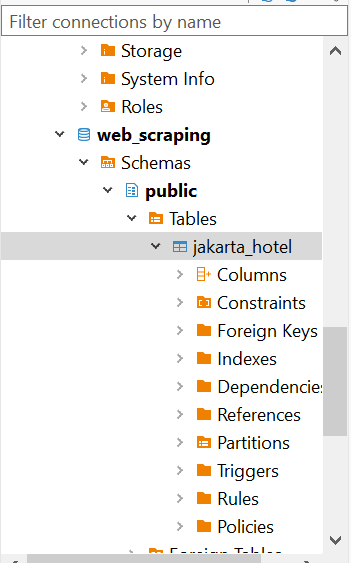
</div>


Showing all columns in table

<div>
  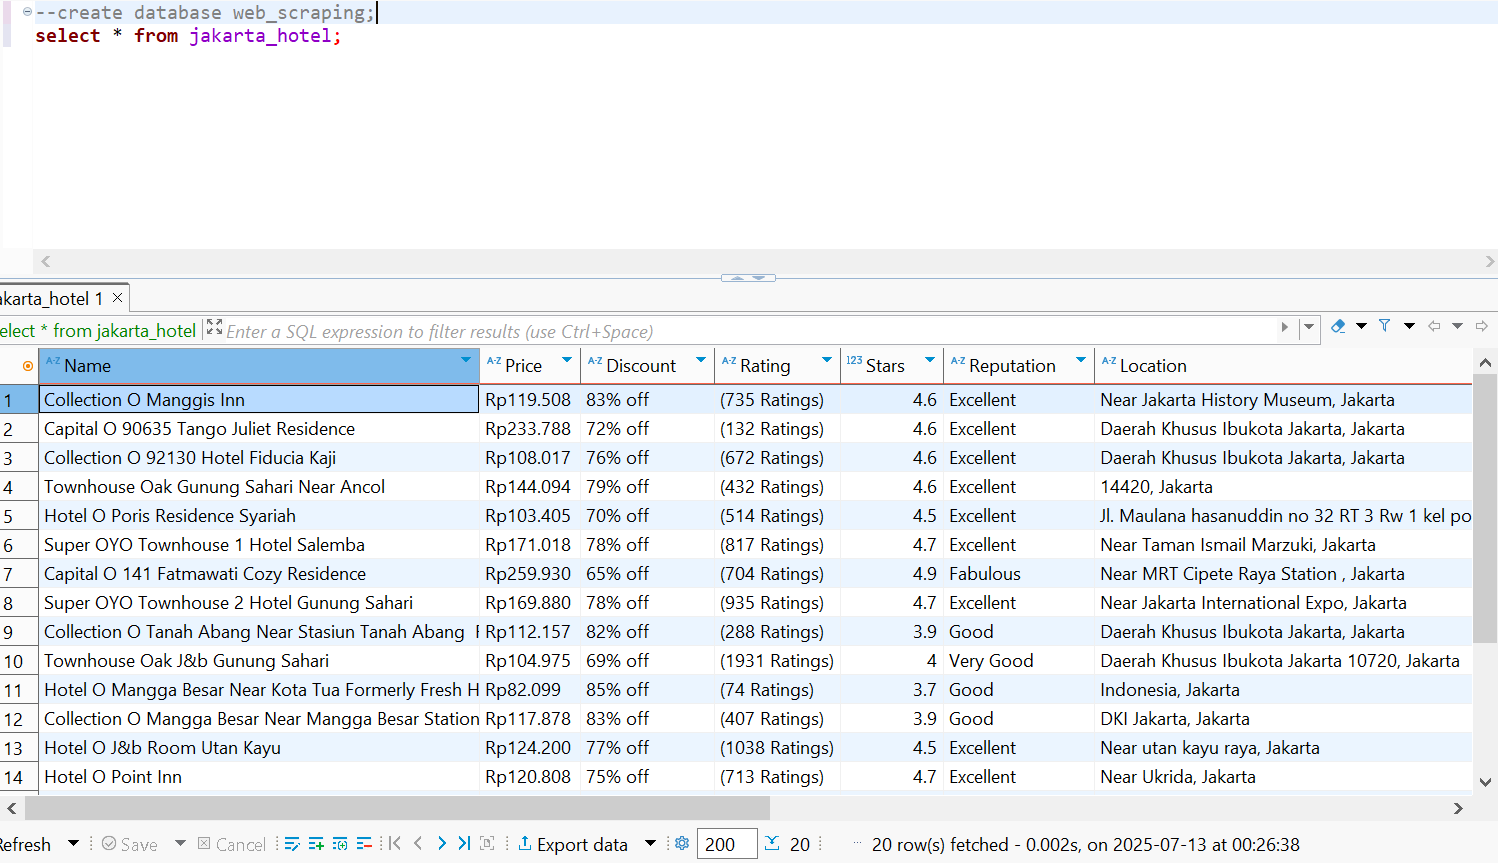
</div>

## 5. SQL Query Test Run

<h4>1st Query: Hotel harga terjangkau kualitas tinggi</h4>
<div>
  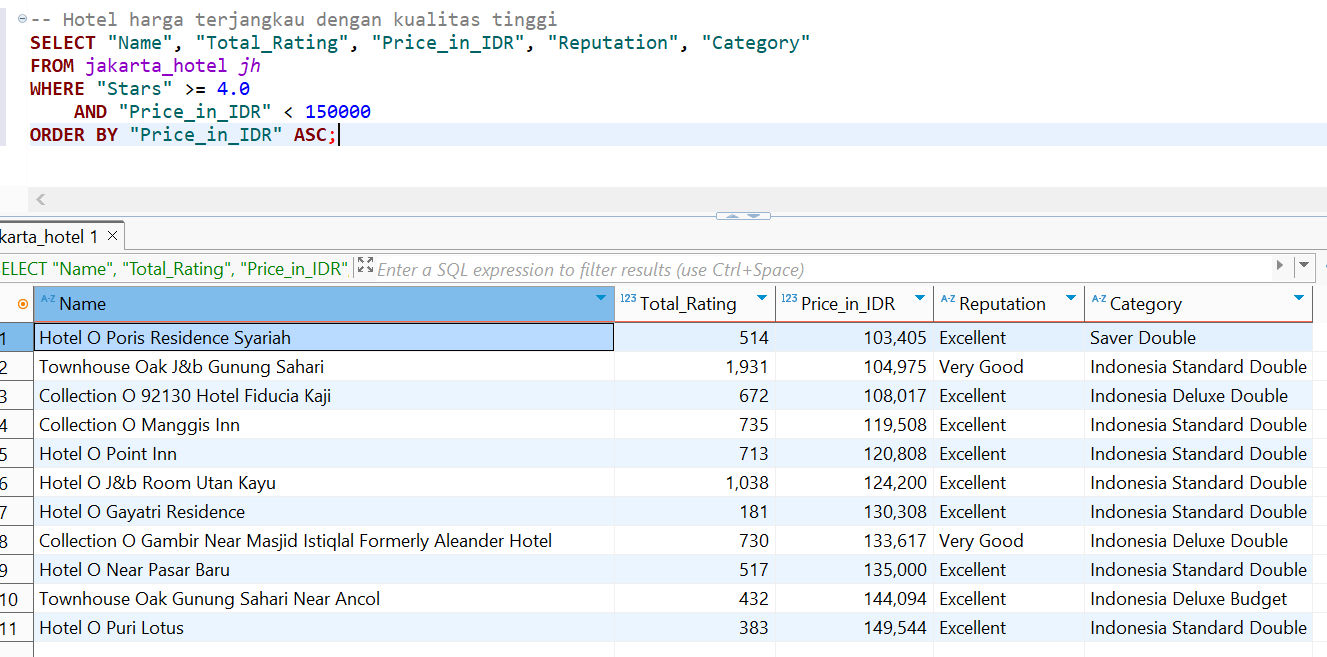
</div>

<h4>2nd Query: How much money is saved from discount given by the hotel (Money Worth?)</h4>
<div>
  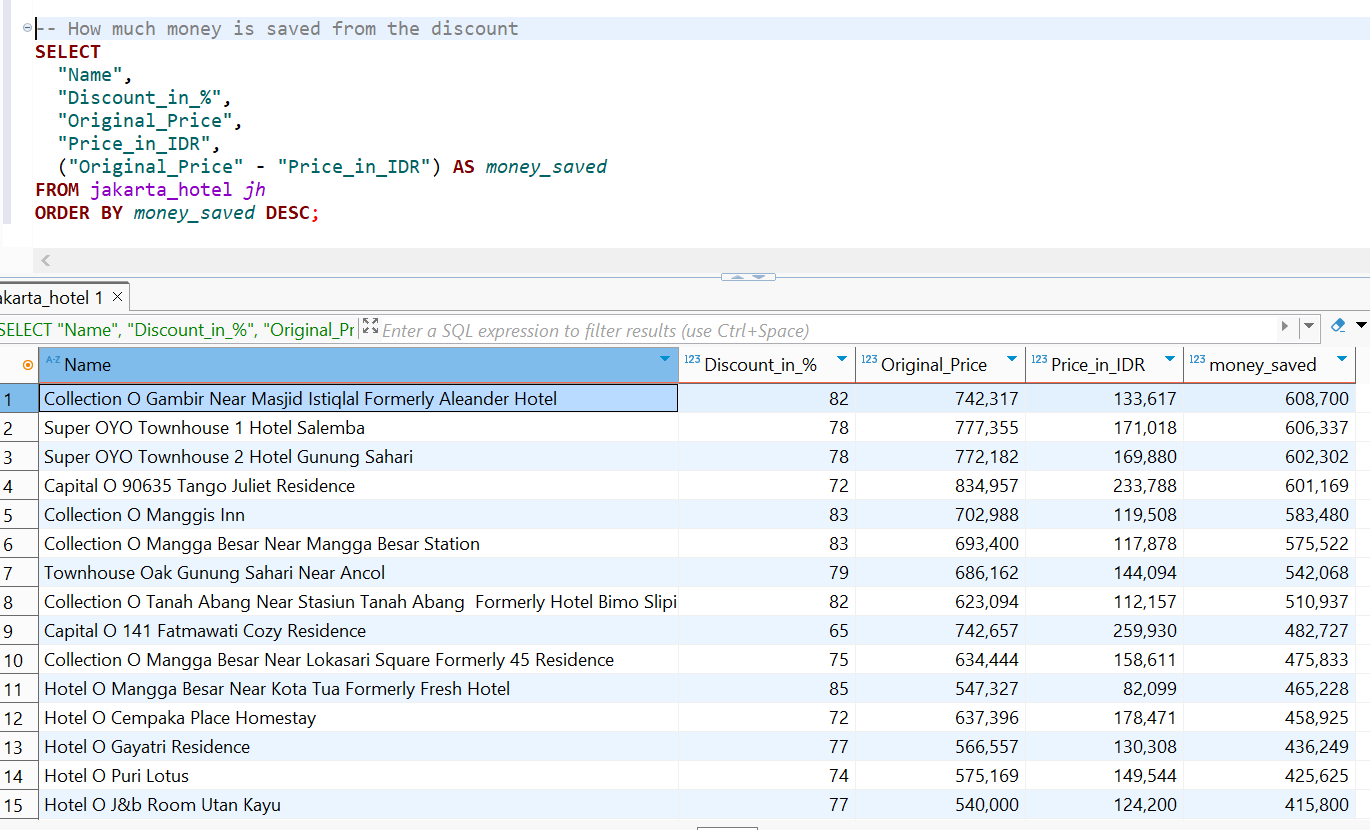
</div>

<h4>3rd Query: Jumlah hotel tiap lokasi unik (sayangnya input lokasi jelek dan perlu dibereskan)</h4>
<div>
  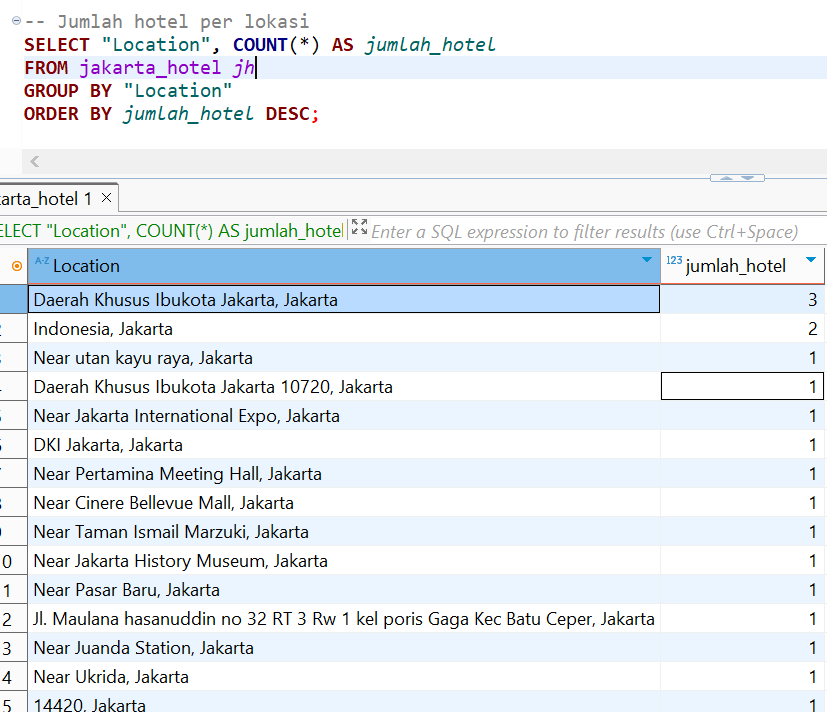
</div>

<h4>4th Query: Rata-rata rating (jumlah reviewer) dan kategori hotel</h4>
<div>
  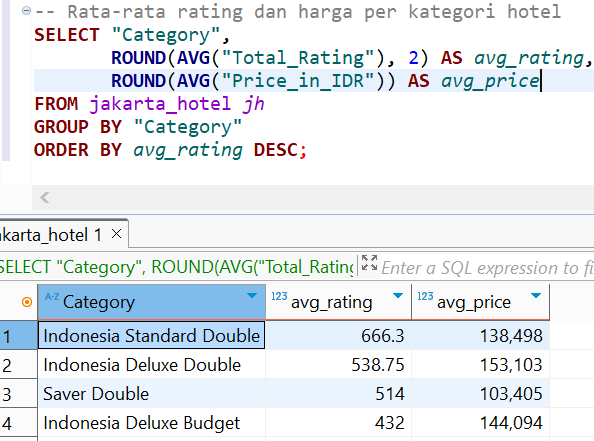
</div>

<h4>5th Query: Hotel dengan Reputasi Tertinggi: Fabulous and Excellent</h4>
<div>
  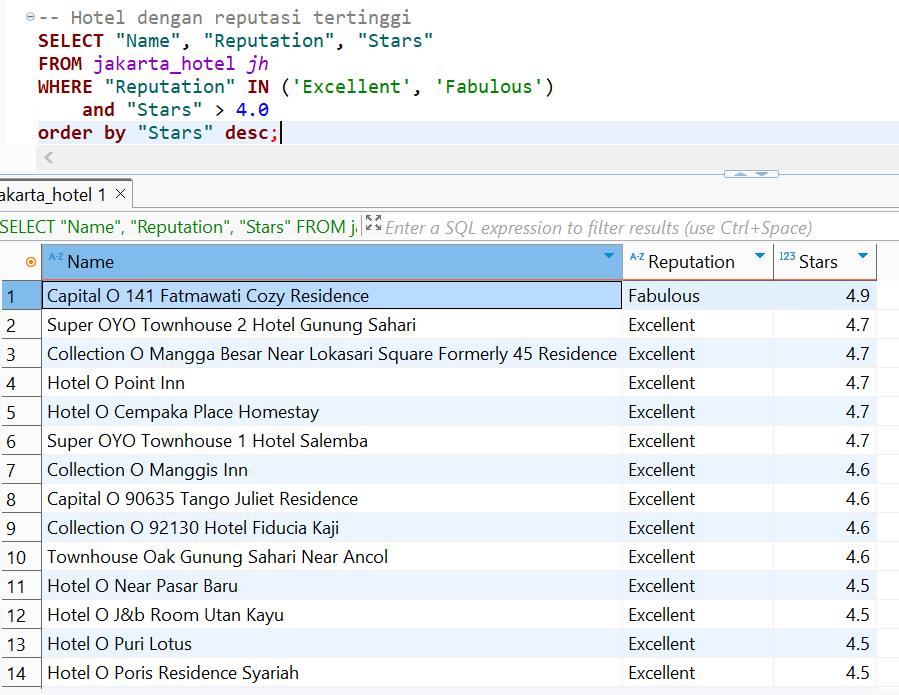
</div>

<h4>6th Query: Most Reviewed Hotel</h4>
<div>
  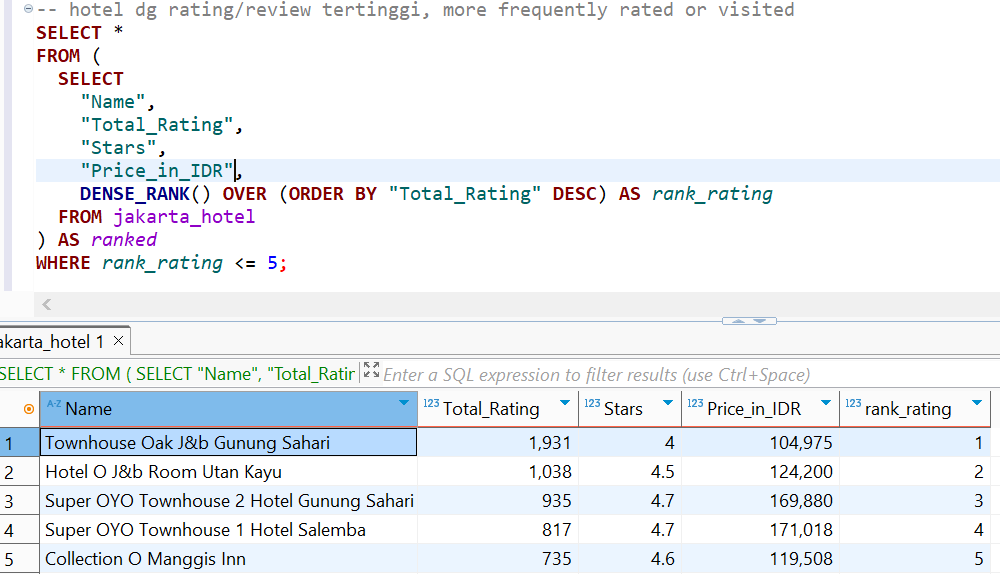
</div>

<h4>7th Query: Price Order for Each Hotel Category</h4>
<div>
  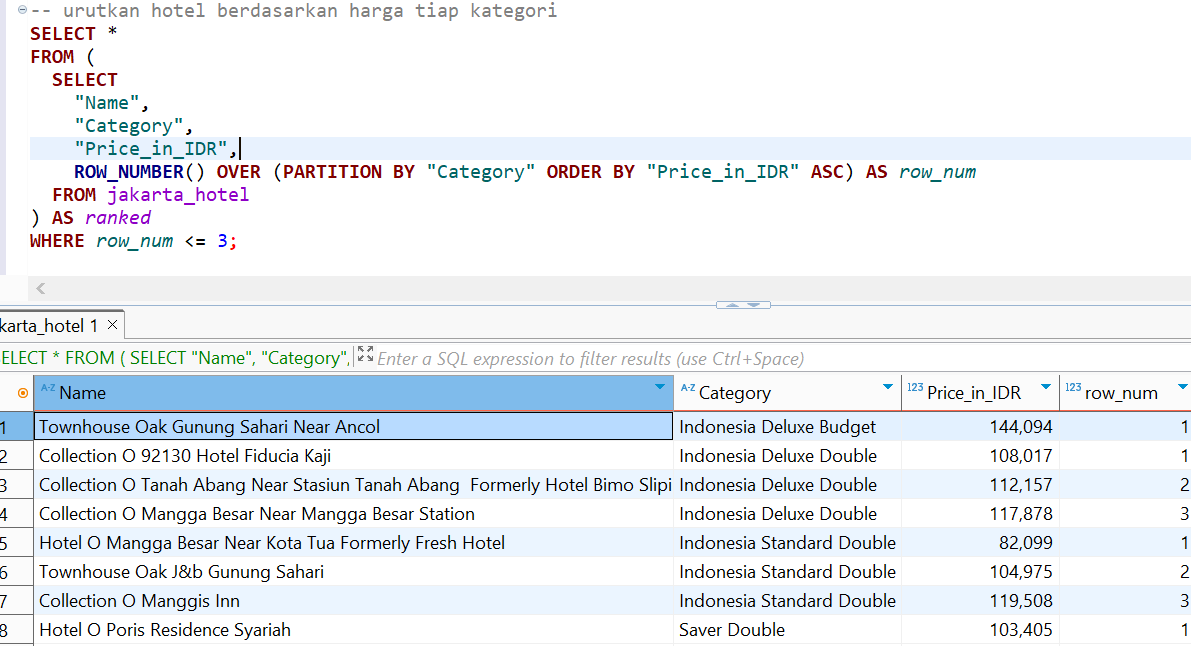
</div>

<h4>8th Query: Diskon tertinggi di tiap lokasi unik</h4>
<div>
  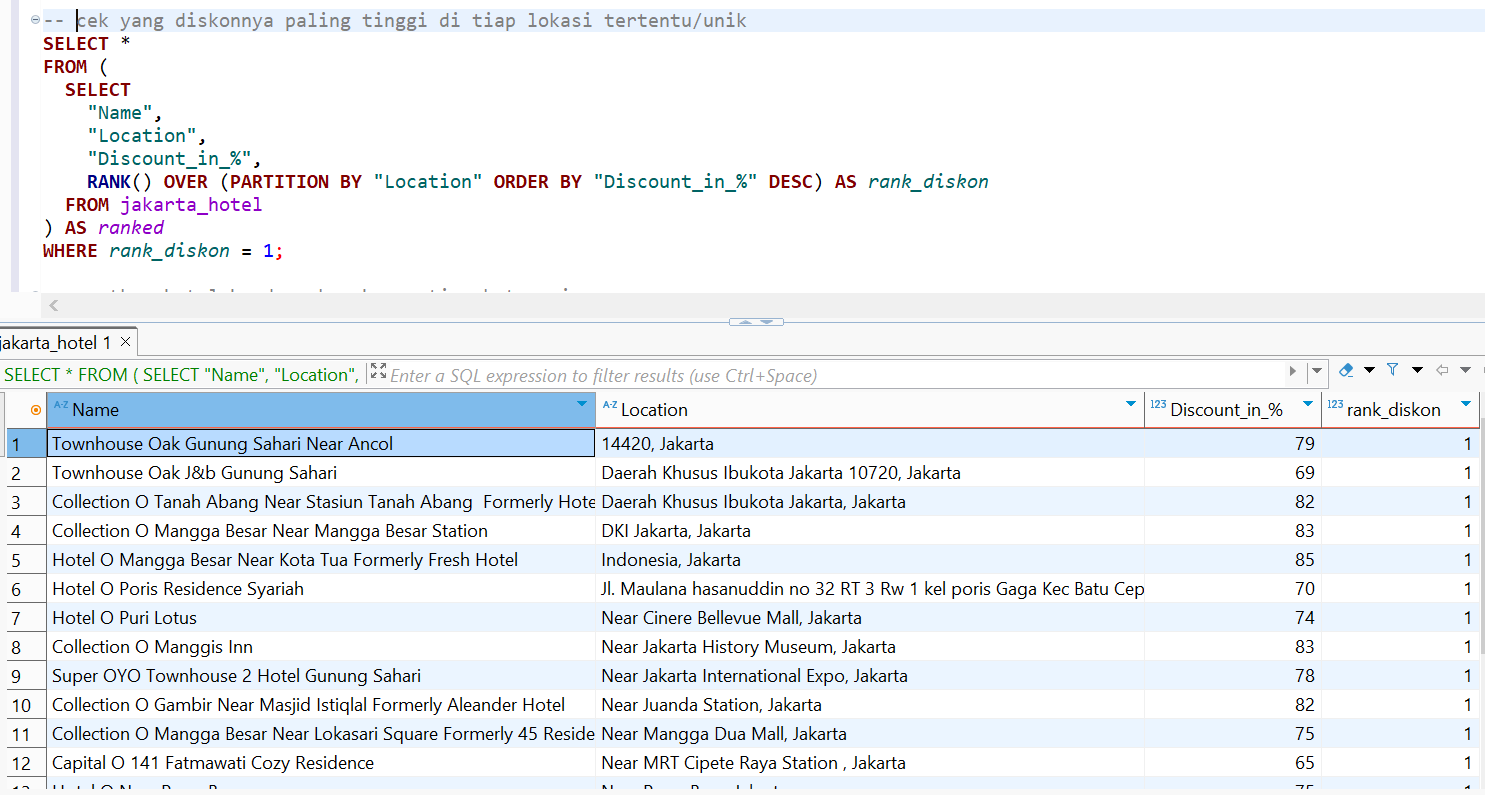
</div>

<h4>9th Query: Price Category</h4>
<div>
  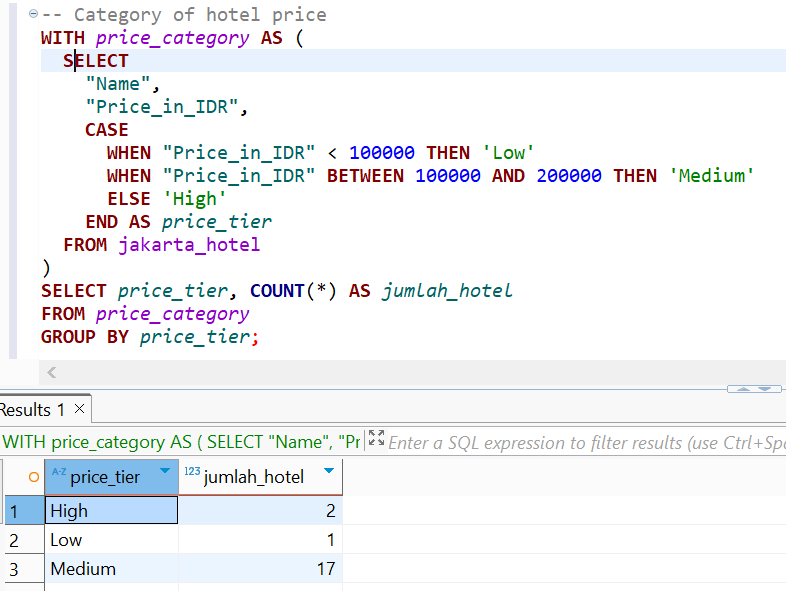
</div>


## 6. Regex

Secara general, regex itu artinya regular expression, kita mencari pola atau pattern regular dari string dalam bahasa pemrograman, contohnya: @, !, #, $, %, ^, &, *, (, ), -, +, /, \, ...

Berikut adalah penjelasan dari beberapa regex yang digunakan di assignment:

- `r'(\d+)'`: \d+: satu atau lebih digit angka (0-9), () : menangkap hasil regex (group)

Contoh: '65' dari '65% off'

Artinya: ambil angka bulat dari string, cocok untuk rating, diskon, atau total review.

- `r'([\d.]+)'`: \d: digit angka, .: titik desimal, [\d.]+: satu atau lebih digit atau titik

Contoh: '450.000' dari 'Rp 450.000'

Artinya: ambil angka yang mengandung titik, cocok untuk harga.

- `r'(\d+\.?\d*)'`: \d+: satu atau lebih angka, \.?: titik opsional, \d*: nol atau lebih angka setelah titik

Contoh: '8.5', '9'

Artinya: ambil angka yang bisa berupa desimal atau bulat, cocok untuk rating seperti '8.4 / 10'.